# KE 5018 - Workshop 2B Sentosa Bank Customer Propensity Modelling

## Import libraries

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import myUtilities as mu

from keras import models
from keras import layers
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

Using TensorFlow backend.


## Load data

In [2]:
X = np.load(os.path.join('data', 'x-train.npy'))
y = np.load(os.path.join('data', 'y-train.npy'))

In [3]:
X[0]

array([-1.08471883, -0.8382461 , -0.03299182,  0.14378335,  0.33764937,
        0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ])

In [4]:
X.shape

(1643, 23)

In [5]:
NN_INPUT = X.shape[1]
NN_INPUT

23

In [6]:
y[:5]

array(['None', 'None', 'None', 'None', 'None'], dtype=object)

In [7]:
y.shape

(1643,)

In [8]:
# Shuffle the data.
X, y = shuffle(X, y, random_state=11)

In [9]:
y_df = pd.get_dummies(y)
y_df.head()

,A,B,None
0,1,0,0
1,0,0,1
2,1,0,0
3,0,1,0
4,1,0,0


In [10]:
one_hot_y = y_df.values
one_hot_y

array([[1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       ..., 
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

## Fit a base model

In [11]:
# Train-validation split
X_train, X_test, one_hot_y_train, one_hot_y_test, y_train, y_test = train_test_split(X, one_hot_y, y, test_size=0.33, random_state=42, stratify=y)

In [12]:
# Model Definition
model = models.Sequential()
model.add(layers.Dropout(0.2, input_shape=(NN_INPUT,)))
model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [13]:
# Compile the Model.
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# Training the model
my_metrics = mu.Metrics([X_train, one_hot_y_train])
history = model.fit(X_train,
                    one_hot_y_train,
                    epochs=2000,
                    batch_size=128,
                    validation_data=(X_test, one_hot_y_test),
                    class_weight={0:1, 1:1, 2:2.25},
                    callbacks=[my_metrics],
                    verbose=0)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


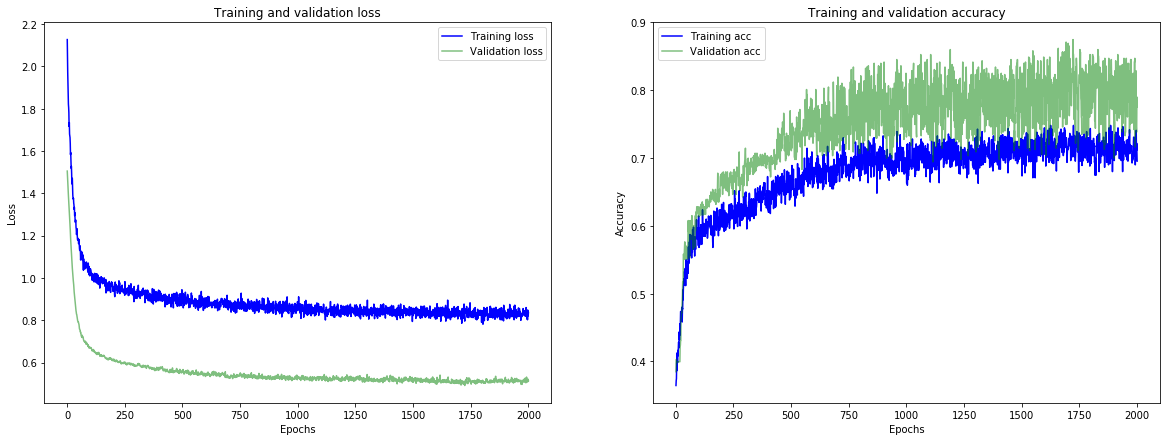

In [15]:
# Plotting the training and validation loss, accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(20, 7))

plt.subplot(121)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='green', alpha=.5)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(122)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color='green', alpha=.5)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [16]:
my_metrics.val_f1s_macro[-10:]

[0.71590257526449985,
 0.67506027241801414,
 0.7267243270614907,
 0.77948220708401694,
 0.83124911737028473,
 0.73216998959863722,
 0.72241583382324126,
 0.71863540307042084,
 0.78743825786577881,
 0.76668682066515104]

In [18]:
my_metrics.train_f1s_macro[-10:]

[0.74334501807372189,
 0.69963880131549461,
 0.76504490841320083,
 0.80871977988128718,
 0.86667699625856154,
 0.77448034923037046,
 0.76359422878785155,
 0.75373604499399371,
 0.80795102199483881,
 0.77154452028797282]

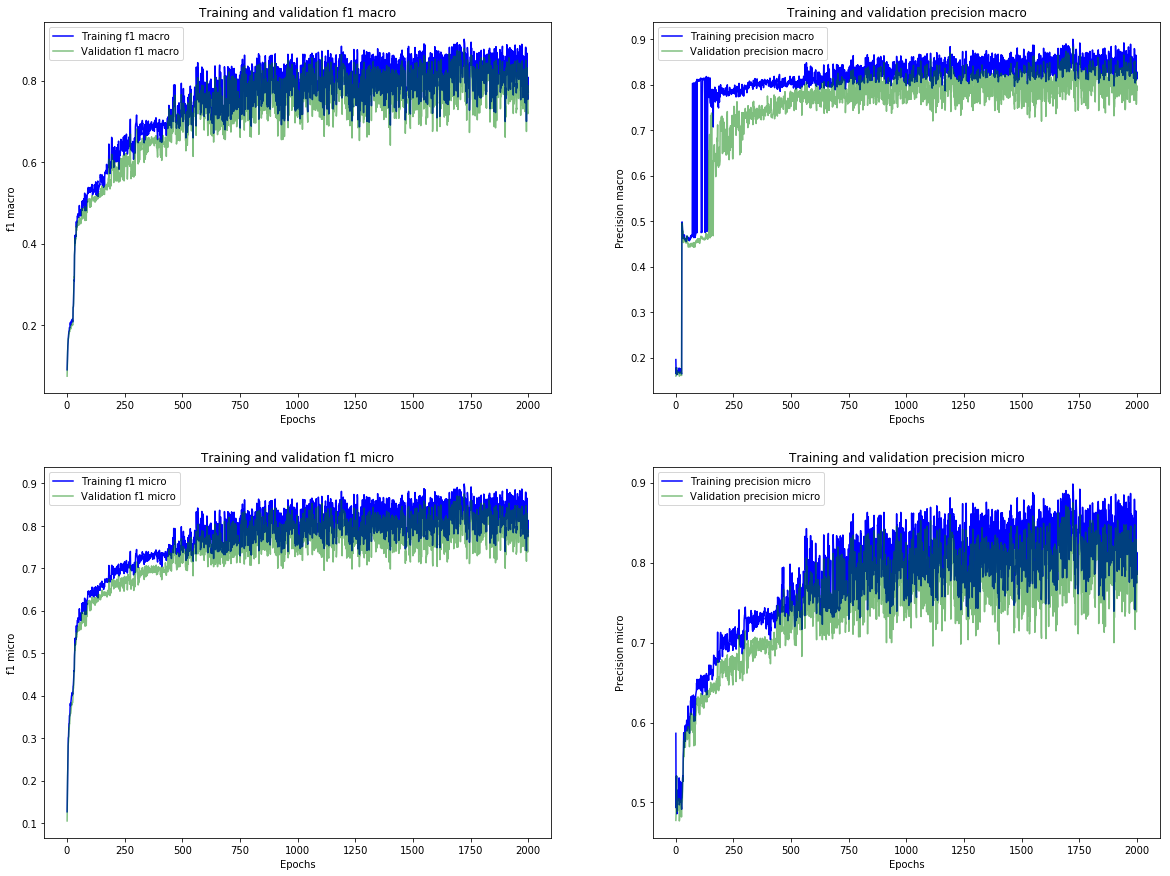

In [19]:
# Plotting the training and validation f1, precision
train_f1 = my_metrics.train_f1s_macro
val_f1 = my_metrics.val_f1s_macro

train_prec = my_metrics.train_precisions_macro
val_prec = my_metrics.val_precisions_macro

train_f1_micro = my_metrics.train_f1s_micro
val_f1_micro = my_metrics.val_f1s_micro

train_prec_micro = my_metrics.train_precisions_micro
val_prec_micro = my_metrics.val_precisions_micro

epochs = range(1, len(my_metrics.train_f1s_macro) + 1)

plt.figure(figsize=(20, 15))

plt.subplot(221)
plt.plot(epochs, train_f1, 'b', label='Training f1 macro')
plt.plot(epochs, val_f1, 'b', label='Validation f1 macro', color='green', alpha=.5)
plt.title('Training and validation f1 macro')
plt.xlabel('Epochs')
plt.ylabel('f1 macro')
plt.legend()

plt.subplot(222)
plt.plot(epochs, train_prec, 'b', label='Training precision macro')
plt.plot(epochs, val_prec, 'b', label='Validation precision macro', color='green', alpha=.5)
plt.title('Training and validation precision macro')
plt.xlabel('Epochs')
plt.ylabel('Precision macro')
plt.legend()

plt.subplot(223)
plt.plot(epochs, train_f1_micro, 'b', label='Training f1 micro')
plt.plot(epochs, val_f1_micro, 'b', label='Validation f1 micro', color='green', alpha=.5)
plt.title('Training and validation f1 micro')
plt.xlabel('Epochs')
plt.ylabel('f1 micro')
plt.legend()

plt.subplot(224)
plt.plot(epochs, train_prec_micro, 'b', label='Training precision micro')
plt.plot(epochs, val_prec_micro, 'b', label='Validation precision micro', color='green', alpha=.5)
plt.title('Training and validation precision micro')
plt.xlabel('Epochs')
plt.ylabel('Precision micro')
plt.legend()

plt.show()

### Show training and test results

In [20]:
num_y_pred_train = model.predict_classes(X_train)
num_y_pred_train

array([0, 1, 2, ..., 0, 1, 1])

In [21]:
num_y_pred_test = model.predict_classes(X_test)
num_y_pred_test

array([2, 1, 1, 0, 2, 2, 1, 0, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 1, 2, 2, 0, 2, 0, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 0, 2, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 0, 1, 1, 2, 1, 2, 0, 2, 2, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 0, 1, 1, 2, 2, 0, 0,
       1, 2, 2, 2, 2, 0, 1, 2, 1, 2, 0, 1, 1, 0, 2, 2, 0, 2, 1, 2, 2, 2, 0,
       2, 1, 2, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       0, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 0, 0, 1, 1, 2, 1, 1, 2,
       1, 2, 2, 1, 0, 1, 2, 1, 1, 0, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 0, 2, 0,
       0, 1, 0, 2, 0, 0, 1, 1, 0, 1, 1, 2, 1, 2, 2, 1, 2, 0, 2, 2, 2, 2, 1,
       0, 1, 2, 1, 1, 2, 0, 1, 2, 0, 2, 1, 1, 0, 0, 2, 1, 1, 2, 2, 1, 1, 0,
       2, 1, 0, 0, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 0, 2, 1, 2, 1, 2, 2, 0, 0,
       0, 1, 2, 2, 2, 0, 0, 1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2,
       2, 1, 2, 2, 2, 0, 2, 1, 0, 2, 0, 0, 2, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2,
       2, 1,

In [22]:
num_y_test = [np.where(r==1)[0][0] for r in one_hot_y_test]
num_y_test[:5]

[2, 1, 1, 0, 0]

In [23]:
le = LabelEncoder()
le.fit(y_train)
num_y_train = le.transform(y_train)
num_y_train[:10]

array([0, 1, 0, 0, 2, 1, 1, 1, 1, 2])

In [24]:
cnf_matrix_train = confusion_matrix(num_y_train, num_y_pred_train)
cnf_matrix_test = confusion_matrix(num_y_test, num_y_pred_test)

Confusion matrix, without normalization
[[149   0 181]
 [  0 330   0]
 [ 31  24 385]]
Confusion matrix, without normalization
[[ 82   0  81]
 [  0 163   0]
 [ 24  17 176]]


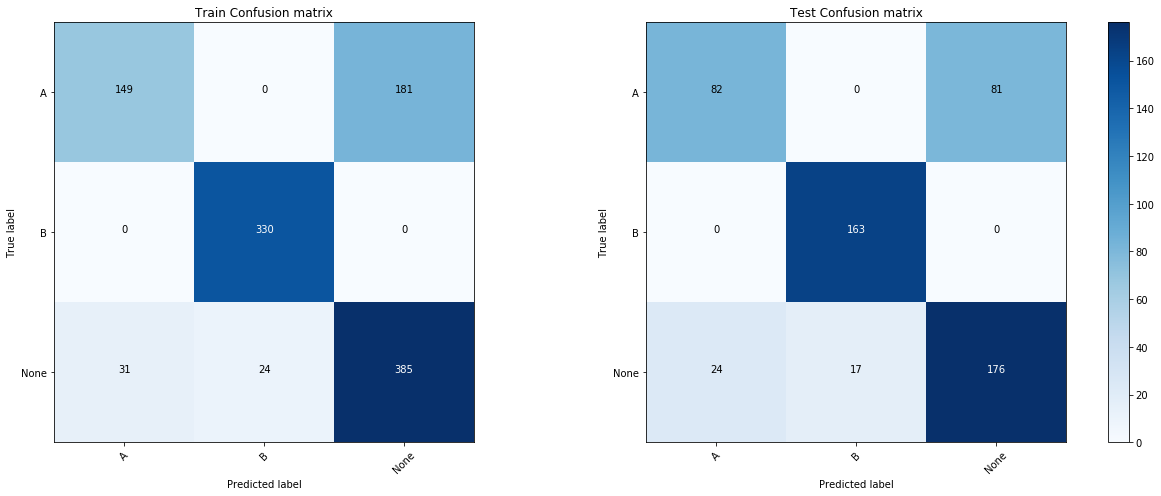

In [25]:
plt.figure(figsize=(20, 7))
plt.subplot(121)
mu.plot_confusion_matrix(cnf_matrix_train, classes=['A', 'B', 'None'], title='Train Confusion matrix')
plt.subplot(122)
mu.plot_confusion_matrix(cnf_matrix_test, classes=['A', 'B', 'None'], title='Test Confusion matrix')
plt.show()

In [26]:
print('Test Results\n\n', classification_report(num_y_test, num_y_pred_test, target_names=['A', 'B', 'None']))

Test Results

              precision    recall  f1-score   support

          A       0.77      0.50      0.61       163
          B       0.91      1.00      0.95       163
       None       0.68      0.81      0.74       217

avg / total       0.78      0.78      0.77       543



## Grid search for a better model

In [27]:
# Range of sizes of neural network for grid search.
param_grid = [
    {'layer1': [16], 'layer2': [16], 'layer3': [0]},
    {'layer1': [32], 'layer2': [16], 'layer3': [0]},
    {'layer1': [32], 'layer2': [32], 'layer3': [0]},
    {'layer1': [32], 'layer2': [16], 'layer3': [8]},
]

In [28]:
# Function to create model, required for KerasClassifier
def create_model_gscv(layer1 = 64, layer2 = 64, layer3 = 64):
    
    # create model
    model = models.Sequential()

    # Add dropout to input
    model.add(layers.Dropout(0.2, input_shape=(NN_INPUT,)))
    
    # Hidden layers
    model.add(layers.Dense(layer1, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(layers.Dropout(0.5))
    if (layer2 > 0) :
        model.add(layers.Dense(layer2, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
        model.add(layers.Dropout(0.5))
    if (layer3 > 0) :
        model.add(layers.Dense(layer3, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
        model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(3, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy']
                  )
    return model

In [29]:
#nn_model = KerasClassifier(build_fn=create_model_gscv, epochs=2000, batch_size=128, callbacks=[my_metrics], verbose=0)
nn_model = KerasClassifier(build_fn=create_model_gscv, epochs=2000, batch_size=128, verbose=0)

In [30]:
# Use 3-fold stratified cross-validation.
#my_metrics = mu.Metrics([X, one_hot_y])
grid = GridSearchCV(estimator=nn_model, param_grid=param_grid, n_jobs=1, cv=3, refit=True, verbose=0, return_train_score=True)
grid_result = grid.fit(X, y, class_weight={0:1, 1:1, 2:2.5})
#grid_result = grid.fit(X, y, class_weight={0:1, 1:1, 2:2.5}, callbacks=[my_metrics])

In [31]:
# Summarize results.
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.796713 using {'layer1': 32, 'layer2': 32, 'layer3': 0}
0.684723 (0.032942) with: {'layer1': 16, 'layer2': 16, 'layer3': 0}
0.796713 (0.018917) with: {'layer1': 32, 'layer2': 16, 'layer3': 0}
0.796713 (0.018744) with: {'layer1': 32, 'layer2': 32, 'layer3': 0}
0.659160 (0.038652) with: {'layer1': 32, 'layer2': 16, 'layer3': 8}


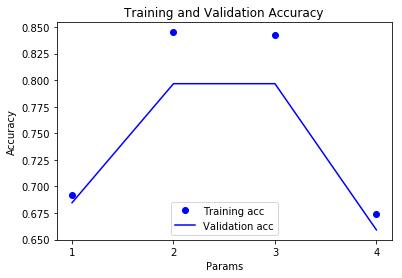

In [32]:
# Plotting the training and validation accuracy
plt.clf()

acc1 = grid_result.cv_results_['mean_train_score']
val_acc1 = grid_result.cv_results_['mean_test_score']

params1 = range(1, len(grid_result.cv_results_['params']) + 1)

plt.plot(params1, acc1, 'bo', label='Training acc')
plt.plot(params1, val_acc1, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Params')
plt.xticks([1, 2, 3, 4])
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Score the best estimator on the test data

In [33]:
X_test = np.load(os.path.join('data', 'x-test.npy'))
y_test = np.load(os.path.join('data', 'y-test.npy'))

In [34]:
le = LabelEncoder()
le.fit(y_test)
num_y_test = le.transform(y_test)
num_y_test[:10]

array([2, 2, 1, 2, 2, 2, 0, 2, 0, 2])

In [35]:
y_pred_best_test = grid_result.predict(X_test)
y_pred_best_test[:10]

array(['None', 'B', 'None', 'None', 'None', 'None', 'None', 'None', 'None',
       'None'], dtype=object)

In [36]:
le = LabelEncoder()
le.fit(y_pred_best_test)
num_y_pred_best_test = le.transform(y_pred_best_test)
num_y_pred_best_test[:10]

array([2, 1, 2, 2, 2, 2, 2, 2, 2, 2])

In [37]:
le.classes_

array(['A', 'B', 'None'], dtype=object)

In [38]:
le.transform(['A', 'B', 'None'])

array([0, 1, 2])

In [39]:
num_y = le.transform(y)
num_y[:10]

array([0, 2, 0, 1, 0, 2, 2, 2, 1, 2])

In [40]:
y_pred_best = grid_result.predict(X)
y_pred_best[:10]

array(['None', 'None', 'None', 'B', 'None', 'None', 'None', 'A', 'B',
       'None'], dtype=object)

In [41]:
le = LabelEncoder()
le.fit(y_pred_best)
num_y_pred_best = le.transform(y_pred_best)
num_y_pred_best[:10]

array([2, 2, 2, 1, 2, 2, 2, 0, 1, 2])

Confusion matrix, without normalization
[[350   0 143]
 [  0 493   0]
 [ 59  45 553]]
Confusion matrix, without normalization
[[  8   0  13]
 [  0   4   5]
 [  9  26 135]]


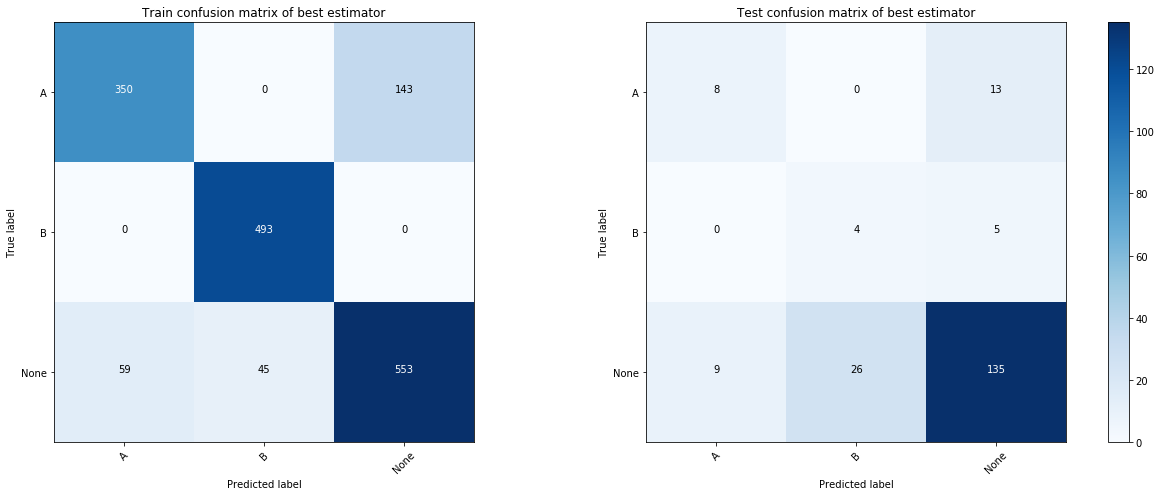

In [42]:
cnf_matrix_best = confusion_matrix(num_y, num_y_pred_best)
cnf_matrix_best_test = confusion_matrix(num_y_test, num_y_pred_best_test)
plt.figure(figsize=(20, 7))
plt.subplot(121)
mu.plot_confusion_matrix(cnf_matrix_best, classes=['A', 'B', 'None'], title='Train confusion matrix of best estimator')
plt.subplot(122)
mu.plot_confusion_matrix(cnf_matrix_best_test, classes=['A', 'B', 'None'], title='Test confusion matrix of best estimator')
plt.show()

In [43]:
print(classification_report(num_y, num_y_pred_best, target_names=['A', 'B', 'None']))

             precision    recall  f1-score   support

          A       0.86      0.71      0.78       493
          B       0.92      1.00      0.96       493
       None       0.79      0.84      0.82       657

avg / total       0.85      0.85      0.85      1643



## Perform precision-recall tradeoff for decision threshold

In [44]:
y_scores = grid_result.predict_proba(X)
y_scores

array([[  4.79272544e-01,   1.71577131e-21,   5.20727456e-01],
       [  6.50209549e-04,   4.94969281e-05,   9.99300241e-01],
       [  4.92811501e-01,   7.58441661e-21,   5.07188499e-01],
       ..., 
       [  1.57712403e-08,   7.09457040e-01,   2.90542960e-01],
       [  5.58441401e-01,   3.93774581e-20,   4.41558599e-01],
       [  5.17718792e-01,   2.87767241e-16,   4.82281238e-01]], dtype=float32)

### Class A

In [45]:
y_scores_A = y_scores[:, 0]
y_scores_A

array([  4.79272544e-01,   6.50209549e-04,   4.92811501e-01, ...,
         1.57712403e-08,   5.58441401e-01,   5.17718792e-01], dtype=float32)

In [46]:
y_A = (y == 'A').astype(int)
y_A

array([1, 0, 1, ..., 0, 1, 1])

In [47]:
np.min(y_scores_A[y_A == 1])

0.33709121

(array([  4.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   9.,  12.,   7.,  17.,   3.,  17.,
         16.,  13.,  22.,  17.,  15.,  16.,  39.,  44.,  35.,  55.,  19.,
         26.,  11.,  32.,   8.,   7.,   3.,  16.,  18.,   0.,   0.,   0.,
          5.,   0.,   0.,   0.,   0.,   5.]),
 array([ 0.33709121,  0.34327109,  0.34945098,  0.35563086,  0.36181075,
         0.36799063,  0.37417052,  0.3803504 ,  0.38653028,  0.39271017,
         0.39889005,  0.40506994,  0.41124982,  0.41742971,  0.42360959,
         0.42978948,  0.43596936,  0.44214925,  0.44832913,  0.45450902,
         0.4606889 ,  0.46686879,  0.47304867,  0.47922855,  0.48540844,
         0.49158832,  0.49776821,  0.50394809,  0.51012798,  0.51630786,
         0.52248775,  0.52866763,  0.53484752,  0.5410274 ,  0.54720729,
         0.55338717,  0.55956706,  0.56574694,  0.57192683,  0.57810671,
         0.58428659,  0.59046648,  0.59664636,  0.60282625,  0.60900613,
 

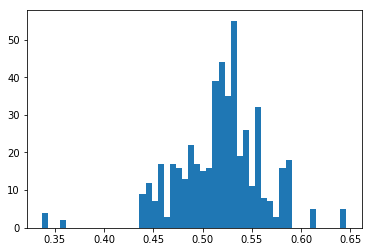

In [48]:
plt.hist(y_scores_A[y_A == 1], bins=50)

(array([ 3.,  1.,  2.,  2.,  2.,  3.,  4.,  2.,  2.,  2.,  3.,  0.,  2.,
         4.,  2.,  2.,  5.,  1.,  3.,  0.,  1.,  2.,  1.,  0.,  0.,  2.,
         0.,  1.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  2.]),
 array([ 0.5003289 ,  0.5021844 ,  0.5040399 ,  0.5058954 ,  0.5077509 ,
         0.5096064 ,  0.5114619 ,  0.5133174 ,  0.5151729 ,  0.5170284 ,
         0.5188839 ,  0.5207394 ,  0.5225949 ,  0.5244504 ,  0.52630589,
         0.52816139,  0.53001689,  0.53187239,  0.53372789,  0.53558339,
         0.53743889,  0.53929439,  0.54114989,  0.54300539,  0.54486089,
         0.54671639,  0.54857189,  0.55042739,  0.55228289,  0.55413839,
         0.55599389,  0.55784939,  0.55970489,  0.56156039,  0.56341589,
         0.56527139,  0.56712689,  0.56898239,  0.57083789,  0.57269339,
         0.57454889,  0.57640439,  0.57825989,  0.58011539,  0.58197089,
         0.58382639,  0.58568189,  0.58753739,  0.58939289,

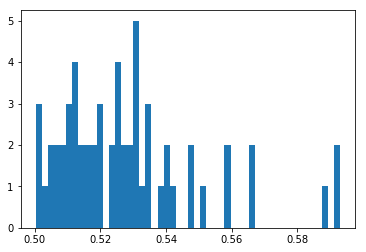

In [49]:
plt.hist(y_scores_A[(y_A == 0) & (y_scores_A > .5)], bins=50)

In [50]:
print('FP > .5 =%f\n.5 < FP < .6 =%f' %
      (len(y_scores_A[(y_A == 0) & (y_scores_A >= .5)]), len(y_scores_A[(y_A == 0) & (y_scores_A > .5) & (y_scores_A < .6)])))

FP > .5 =59.000000
.5 < FP < .6 =59.000000


In [51]:
precisionsA, recallsA, thresholdsA = precision_recall_curve(y_A, y_scores_A)

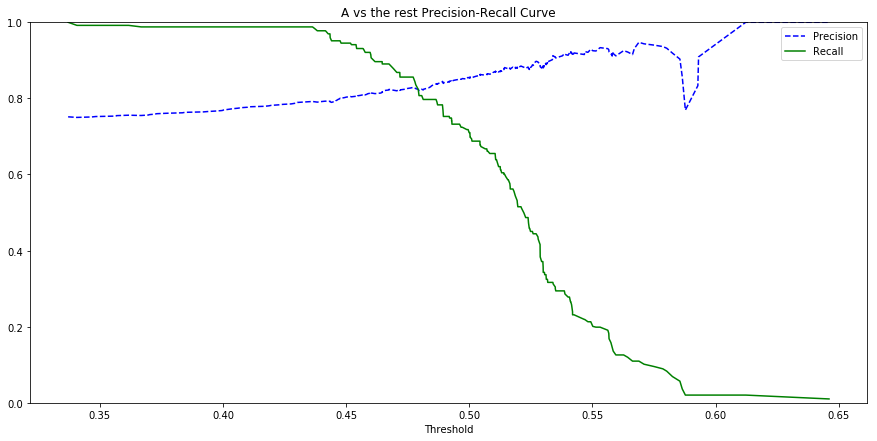

In [52]:
plt.figure(figsize=(15, 7))
plt.plot(thresholdsA, precisionsA[:-1], 'b--', label='Precision')
plt.plot(thresholdsA, recallsA[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
#plt.xlim([0, 1])
plt.legend()
plt.ylim([0, 1])
plt.title('A vs the rest Precision-Recall Curve')
plt.show()

In [53]:
threshold = .6
y_A_pred_6 = (y_scores_A > threshold)
y_A_pred_6

array([False, False, False, ..., False, False, False], dtype=bool)

In [54]:
pc_scores = [[threshold, precision_score(y_A, (y_scores_A > threshold)), recall_score(y_A, (y_scores_A > threshold))]
             for threshold in [.5, .55, .6, .65]]
pd.DataFrame(pc_scores, columns=['Threshold', 'Precision', 'Recall'])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Threshold,Precision,Recall
0,0.50,0.855746,0.709939
1,0.55,0.925234,0.200811
2,0.60,1.000000,0.020284
3,0.65,0.000000,0.000000


### Class B

In [55]:
y_scores_B = y_scores[:, 1]
y_scores_B

array([  1.71577131e-21,   4.94969281e-05,   7.58441661e-21, ...,
         7.09457040e-01,   3.93774581e-20,   2.87767241e-16], dtype=float32)

In [56]:
y_B = (y == 'B').astype(int)
y_B

array([0, 0, 0, ..., 1, 0, 0])

In [57]:
np.min(y_scores_B[y_B == 1])

0.6940223

(array([ 19.,   0.,  14.,   0.,  28.,   0.,   0.,   0.,  24.,   0.,  17.,
          0.,  16.,  12.,   0.,   0.,  36.,   0.,   0.,   0.,  37.,   0.,
         23.,   0.,  21.,  16.,  84.,   0.,   0.,  21.,   0.,   0.,  13.,
         17.,  15.,   0.,   0.,   0.,  14.,   0.,  12.,  22.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,  32.]),
 array([ 0.6940223 ,  0.69720976,  0.70039722,  0.70358469,  0.70677215,
         0.70995961,  0.71314708,  0.71633454,  0.719522  ,  0.72270947,
         0.72589693,  0.72908439,  0.73227186,  0.73545932,  0.73864678,
         0.74183425,  0.74502171,  0.74820917,  0.75139664,  0.7545841 ,
         0.75777156,  0.76095903,  0.76414649,  0.76733395,  0.77052142,
         0.77370888,  0.77689634,  0.78008381,  0.78327127,  0.78645873,
         0.7896462 ,  0.79283366,  0.79602112,  0.79920859,  0.80239605,
         0.80558351,  0.80877098,  0.81195844,  0.8151459 ,  0.81833337,
         0.82152083,  0.82470829,  0.82789576,  0.83108322,  0.83427068,
 

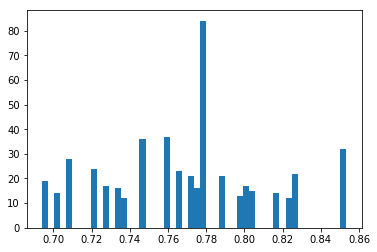

In [58]:
plt.hist(y_scores_B[y_B == 1], bins=50)

(array([ 2.,  0.,  4.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  3.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  2.,  1.,
         2.,  0.,  1.,  3.,  1.,  0.,  0.,  0.,  3.,  0.,  2.,  0.,  1.,
         0.,  1.,  0.,  2.,  2.,  1.,  1.,  0.,  2.,  2.,  1.]),
 array([ 0.50121737,  0.50691234,  0.51260732,  0.5183023 ,  0.52399728,
         0.52969226,  0.53538724,  0.54108222,  0.5467772 ,  0.55247218,
         0.55816716,  0.56386214,  0.56955712,  0.5752521 ,  0.58094708,
         0.58664206,  0.59233704,  0.59803202,  0.60372699,  0.60942197,
         0.61511695,  0.62081193,  0.62650691,  0.63220189,  0.63789687,
         0.64359185,  0.64928683,  0.65498181,  0.66067679,  0.66637177,
         0.67206675,  0.67776173,  0.68345671,  0.68915169,  0.69484667,
         0.70054165,  0.70623662,  0.7119316 ,  0.71762658,  0.72332156,
         0.72901654,  0.73471152,  0.7404065 ,  0.74610148,  0.75179646,
         0.75749144,  0.76318642,  0.7688814 ,  0.77457638,

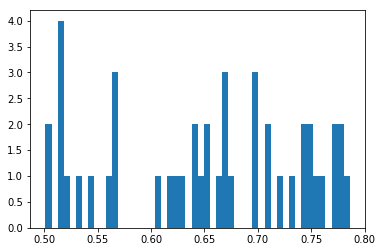

In [59]:
plt.hist(y_scores_B[(y_B == 0) & (y_scores_B > .5)], bins=50)

In [60]:
print('FP > .95 =%f\n.5 < FP < .95 =%f' %
      (len(y_scores_B[(y_B == 0) & (y_scores_B >= .95)]), len(y_scores_B[(y_B == 0) & (y_scores_B > .5) & (y_scores_B < .95)])))

FP > .95 =0.000000
.5 < FP < .95 =45.000000


In [61]:
precisionsB, recallsB, thresholdsB = precision_recall_curve(y_B, y_scores_B)

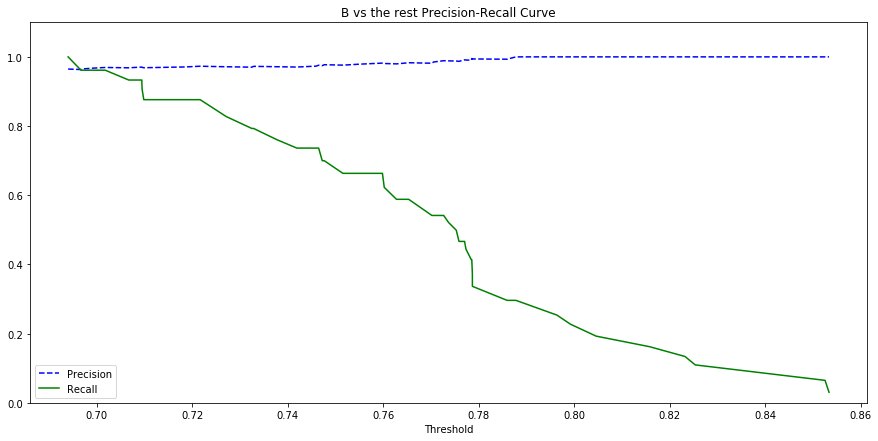

In [62]:
plt.figure(figsize=(15, 7))
plt.plot(thresholdsB, precisionsB[:-1], 'b--', label='Precision')
plt.plot(thresholdsB, recallsB[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
#plt.xlim([0, 1])
plt.legend()
plt.ylim([0, 1.1])
plt.title('B vs the rest Precision-Recall Curve')
plt.show()

In [63]:
pc_scores = [[threshold, precision_score(y_B, (y_scores_B > threshold)), recall_score(y_B, (y_scores_B > threshold))]
             for threshold in [.5, .55, .6, .65, .7, .75]]
pd.DataFrame(pc_scores, columns=['Threshold', 'Precision', 'Recall'])

,Threshold,Precision,Recall
0,0.50,0.916357,1.000000
1,0.55,0.931947,1.000000
2,0.60,0.939048,1.000000
3,0.65,0.953578,1.000000
4,0.70,0.969325,0.961460
5,0.75,0.976119,0.663286


## Fit the best model to all the data

In [64]:
all_X = np.append(X, X_test, axis=0)
all_y = np.append(y, y_test, axis=0)

In [65]:
all_X.shape

(1843, 23)

In [66]:
all_y.shape

(1843,)

In [67]:
all_y_df = pd.get_dummies(all_y)
all_y_df.head()

,A,B,None
0,1,0,0
1,0,0,1
2,1,0,0
3,0,1,0
4,1,0,0


In [68]:
one_hot_all_y = all_y_df.values
one_hot_all_y

array([[1, 0, 0],
       [0, 0, 1],
       [1, 0, 0],
       ..., 
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [75]:
# Model Definition
final_model = models.Sequential()
final_model.add(layers.Dropout(0.2, input_shape=(NN_INPUT,)))
final_model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
final_model.add(layers.Dropout(0.5))
final_model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
final_model.add(layers.Dropout(0.5))
final_model.add(layers.Dense(3, activation='softmax'))

In [76]:
# Compile the Model.
final_model.compile(optimizer='rmsprop',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


In [77]:
# Training the model
my_metrics = mu.Metrics([all_X, one_hot_all_y])
history = final_model.fit(all_X,
                          one_hot_all_y,
                          epochs=2000,
                          batch_size=128,
                          class_weight={0: 1, 1: 1, 2: 2.25},
                          verbose=0)

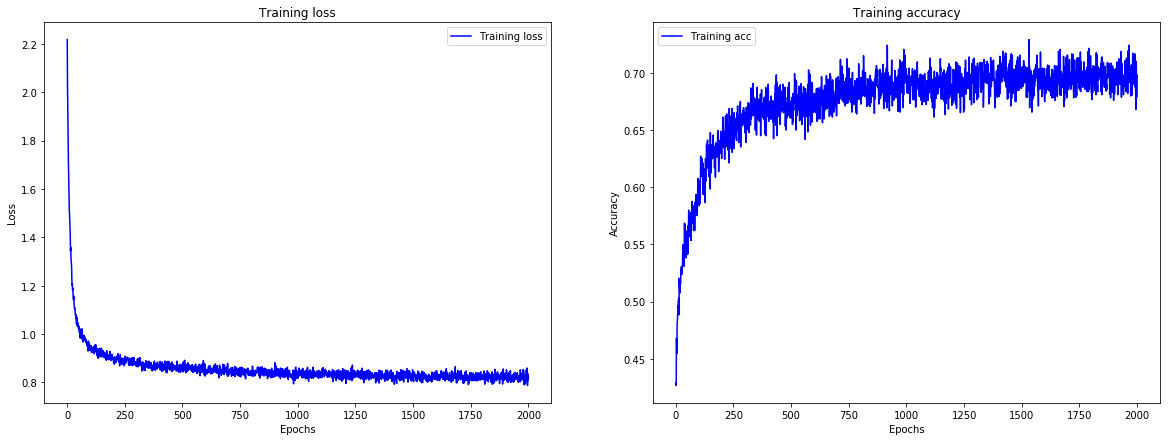

In [78]:
# Plotting the training and validation loss, accuracy
loss = history.history['loss']
acc = history.history['acc']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(20, 7))

plt.subplot(121)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [79]:
final_model.save(os.path.join('data', 'final_model.h5'))